In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 
from tensorflow import keras

In [2]:
df = pd.read_csv('../Data/features_3_sec.csv')
df.head() 

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
df.shape

(9990, 60)

In [4]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [5]:
df =df.drop(['filename'],axis=1)

In [6]:
audio_recording = "./Data/genres_original/country/country.00050.wav"
data,  sr = librosa.load(audio_recording)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
librosa.load(audio_recording, sr=45600)

(array([ 0.04446705,  0.06373049,  0.05768819, ..., -0.13878523,
        -0.11868108, -0.05903753], dtype=float32),
 45600)

In [8]:
import IPython
IPython.display.Audio(data=data, rate=sr)

## Raw Wave Files

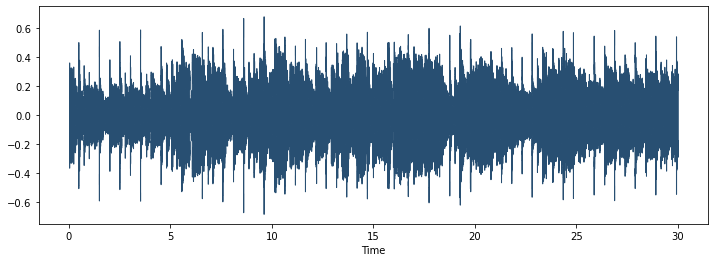

In [9]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, color="#284F72")
plt.show()

## Spectrograms

A spectrogram is a visual way of representing the signal loudness of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

<ipython-input-10-6ff8b0ee93be>:4: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')


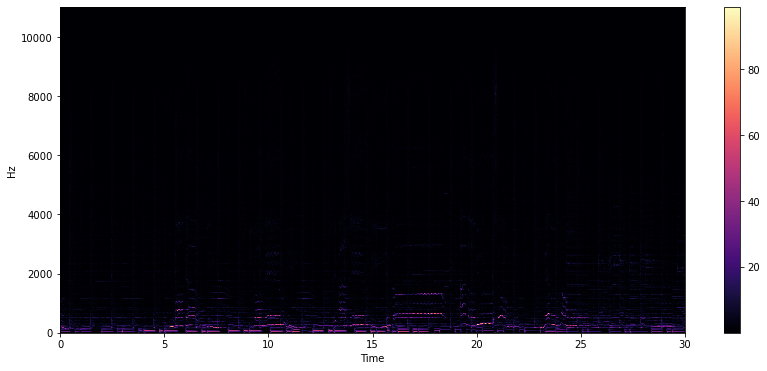

In [10]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

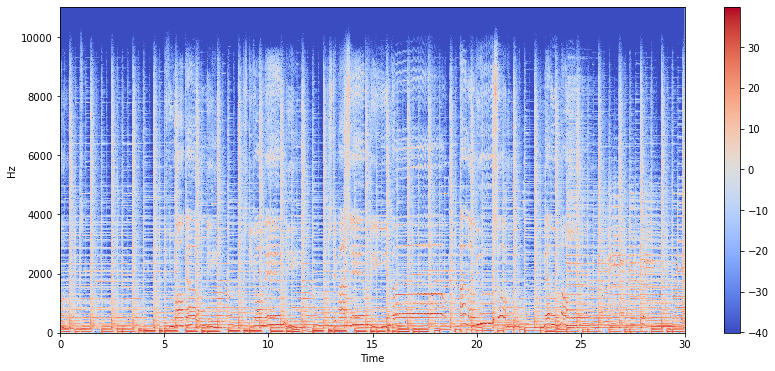

In [11]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## Spectral Rolloff

It is a measure that helps characterize the spectral content of an audio signal by determining the frequency below which a certain percentage of the total spectral energy lies. In simpler terms, spectral rolloff identifies the point in a frequency spectrum below which a specific portion of the signal's energy is concentrated.

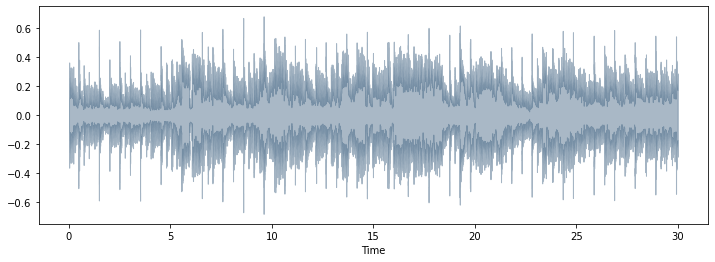

In [12]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(y=data+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.4, color="#284F72")

## Chroma Features

In Western music, the term chroma feature or chromagram closely relates to twelve different pitch classes.
(pitch class = set of all pitches that are a whole number of octaves apart. example: pitch class C stands for all possible Cs, in whatever octave position.)

Chroma-based features (aka "pitch class profiles") are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale.

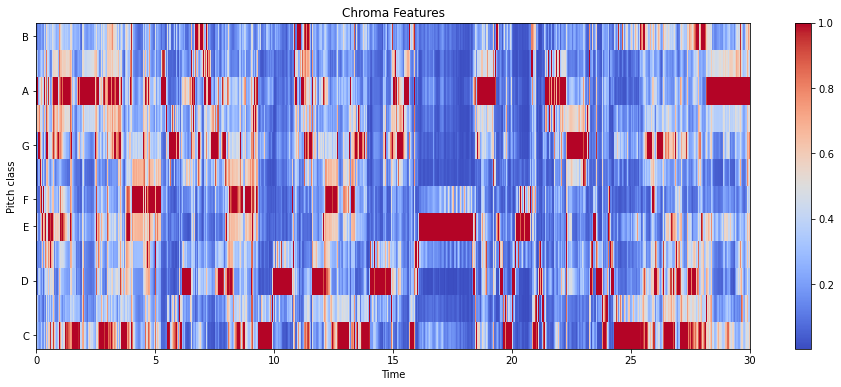

In [13]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(y=data, sr=sr)
plt.figure(figsize=(16, 6))
lplt.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

## Zero Crossing Rate

The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. Its value has been widely used in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.

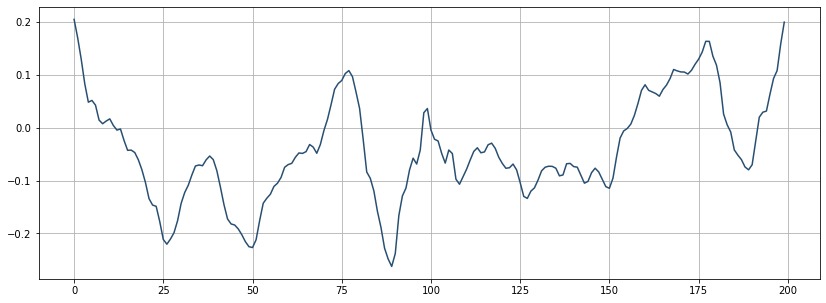

In [14]:
start = 1000
end = 1200
plt.figure(figsize=(14,5))
plt.plot(data[start:end], color="#284F72")
plt.grid()

In [15]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print(f"The number of zero-crossings is :", sum(zero_cross_rate))

The number of zero-crossings is : 8


## Feature Extraction



In [16]:
class_list = df.iloc[:, -1]
convertor = LabelEncoder()
y = convertor.fit_transform(class_list)
print(df.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [17]:
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype = float))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("y_train:", len(y_train))
print("y_test:", len(y_test))

y_train: 7992
y_test: 1998


## Artificial Neural Network (ANN)

In [19]:
from keras.models import Sequential
from keras.layers import Dense

In [20]:
classifier = Sequential()
classifier.add(Dense(units=512, input_dim=58, activation='relu', kernel_initializer='uniform'))
classifier.add(Dense(units=256, activation='relu', kernel_initializer='uniform'))
classifier.add(Dense(units=128, activation='relu', kernel_initializer='uniform'))
classifier.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
classifier.add(Dense(units=32, activation='relu', kernel_initializer='uniform'))
classifier.add(Dense(units=10, activation='softmax', kernel_initializer='uniform'))

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
250/250 [==============================] - 1s 2ms/step - loss: 1.5658 - accuracy: 0.3884
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 1.1403 - accuracy: 0.5542
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.9861 - accuracy: 0.6256
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.8452 - accuracy: 0.6979
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7315 - accuracy: 0.7411
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6455 - accuracy: 0.7741
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5419 - accuracy: 0.8107
Epoch 8/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4569 - accuracy: 0.8443
Epoch 9/100
250/250 [==============================] - 1s 2ms/step - loss: 0.3799 - accuracy: 0.8692
Epoch 10/100
250/250 [==============================] - 1s 2ms/step - loss: 0.3272 - accura

In [21]:
#Evaluation of model before Hyperparameter Tuning

## Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

## accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
print("Precision: ", round(precision_score(y_test, y_pred, average='weighted'),3))
print("Recall: ", round(recall_score(y_test, y_pred, average='weighted'), 3))
print("F1 Score: ", round(f1_score(y_test, y_pred, average='weighted'), 3))

63/63 [==============================] - 0s 1ms/step
Accuracy:  0.897
Precision:  0.899
Recall:  0.897
F1 Score:  0.897


### Hyperparameter Tuning

In [22]:
# Implementation for GridSearchCV
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model(init='uniform', units1=512, units2=256, units3=128, units4=64, units5=32):
    classifier = Sequential()
    classifier.add(Dense(units=units1, input_dim=58, activation='relu', kernel_initializer=init))
    classifier.add(Dense(units=units2, activation='relu', kernel_initializer=init))
    classifier.add(Dense(units=units3, activation='relu', kernel_initializer=init))
    classifier.add(Dense(units=units4, activation='relu', kernel_initializer=init))
    classifier.add(Dense(units=units5, activation='relu', kernel_initializer=init))
    classifier.add(Dense(units=10, activation='softmax', kernel_initializer=init))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

# Create a KerasClassifier based on the defined model
model = KerasClassifier(build_fn=create_model, verbose=0, units1=512, units2=256, units3=128, units4=64, units5=32)

# Define the grid search hyperparameters
param_grid = {
    'units1': [512, 256],
    'units2': [256, 128],
    'units3': [128, 64],
    'units4': [64, 32],
    'units5': [32, 16],
    'epochs': [50, 100, 150],
    'batch_size': [32, 64]
}

# Create the GridSearchCV object, then fit grid search to data
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print('Best Parameters Found: %s' % grid_result.best_params_)
print('Best Accuracy Found: %.3f' % grid_result.best_score_)

c:\Users\ryanc\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\ryanc\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\ryanc\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\ryanc\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\ryanc\anaconda3\lib\site-pa

Best Parameters Found: {'batch_size': 32, 'epochs': 100, 'units1': 512, 'units2': 256, 'units3': 128, 'units4': 64, 'units5': 32}
Best Accuracy Found: 0.884


In [23]:
best_params = grid_result.best_params_
best_units1 = best_params['units1']
best_units2 = best_params['units2']
best_units3 = best_params['units3']
best_units4 = best_params['units4']
best_units5 = best_params['units5']
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']

best_model = create_model(units1=best_units1, units2=best_units2, units3=best_units3, units4=best_units4, units5=best_units5)
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

Epoch 1/100
250/250 [==============================] - 3s 8ms/step - loss: 1.6518 - accuracy: 0.3311
Epoch 2/100
250/250 [==============================] - 2s 8ms/step - loss: 1.1683 - accuracy: 0.5265
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 0.9715 - accuracy: 0.6405
Epoch 4/100
250/250 [==============================] - 2s 8ms/step - loss: 0.7953 - accuracy: 0.7172
Epoch 5/100
250/250 [==============================] - 2s 8ms/step - loss: 0.6681 - accuracy: 0.7664
Epoch 6/100
250/250 [==============================] - 2s 8ms/step - loss: 0.5553 - accuracy: 0.8059
Epoch 7/100
250/250 [==============================] - 2s 9ms/step - loss: 0.4705 - accuracy: 0.8352
Epoch 8/100
250/250 [==============================] - 2s 10ms/step - loss: 0.4012 - accuracy: 0.8607
Epoch 9/100
250/250 [==============================] - 2s 10ms/step - loss: 0.3413 - accuracy: 0.8811
Epoch 10/100
250/250 [==============================] - 2s 10ms/step - loss: 0.2817 - acc

In [24]:
#Evaluation of model after Hyperparameter Tuning

## Predicting the Test set results
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

## accuracy, precision, recall, f1-score
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
print("Precision: ", round(precision_score(y_test, y_pred, average='weighted'),3))
print("Recall: ", round(recall_score(y_test, y_pred, average='weighted'), 3))
print("F1 Score: ", round(f1_score(y_test, y_pred, average='weighted'), 3))

63/63 [==============================] - 0s 4ms/step
Accuracy:  0.9
Precision:  0.901
Recall:  0.9
F1 Score:  0.9
